In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('..')
from utils import plot_counts_and_proportion, read_train_transaction, get_categorical_from_df

In [230]:
X, y = read_train_transaction(nrows=5000)

## IDEAS

1. Cierto tipo de tarjetas son normalmente utilizadas para hacer transacciones de cantidades más altas, otras más bajas. El valor de la transacción está en *'TransactionAmt'*, pero deberiamos poner eso en proporción a la tarjeta utilizada. También valdría la pena compararlo con la desviación estandar.

Entonces hay 3 ideas:
estimar _mean_ y _std_
- X[col] / (estimador de X[col] en la categoria utilizada en X[cat].()
- X[col] / coeficiente_variacion  X[col] en la categoria utilizada en X[cat]


*Utilizarlo con:*
tarjeta 6 que es tipo de tarjeta
tarjeta 4 que es compañia
tarjeta 1, que no sé que es
tarjeta 2, que no sé que es
addr1, que histplot hace parecer que significa algo

2. Separar los correos por puntos, para obtener, nombre dominio
Así lo he visto utilizar
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
Haría esto






In [4]:
def prop_col_over_mean_category(X, col, cat, est='mean'):
    '''
    Retorna una columna de tamaño X[col], de tal manera
    que sus componentes son
     X[col] / (estimador de X[col] en la categoria utilizada en X[cat].()
     
     WARNINGS:
         Usar est = 'std' puede propagar NaN si solo hay un elemento en cat.
     
     Inputs:
         X:
             Pandas dataframe
        col:
            column in X
        cat:
            Column in X, category
        est:
            Transformation utilizaed un df.groupby().transform
            Can be median mean or std
    Outputs:
        S: Pandas series
            as described above
    '''
    # Transform('mean') is diff to .mean()
    # Transform returns a df of equal size,
    # .mean() groups by 
    S = X[col] / X.groupby([cat])[col].transform(est)
    return S

In [5]:
i = 2
iindex = X.index[i]
tarjeta_usada_por_transactioni = X.iloc[i, :]['card1']
promedio_de_esa_tarjeta = X.groupby(['card1'])['TransactionAmt'].mean().loc[tarjeta_usada_por_transactioni]
pago_original = X.loc[iindex, 'TransactionAmt']
pago_div_prom_tarjeta = X.loc[iindex, 'TransactionAmt']/ promedio_de_esa_tarjeta

print(f'''
----- CLIENTE {i}  ------
tarjeta_usada_por_transactioni -> {tarjeta_usada_por_transactioni}
promedio de esa tajeta -> {promedio_de_esa_tarjeta}
pago original cliente i -> {pago_original}
pago_div_prom_tarjeta  -> {pago_div_prom_tarjeta}
''')


----- CLIENTE 4  ------
tarjeta_usada_por_transactioni -> 4497
promedio de esa tajeta -> 50.0
pago original cliente i -> 50.0
pago_div_prom_tarjeta  -> 1.0



In [6]:
prop_col_over_mean_category(X, 'TransactionAmt', 'card1', est='mean')

TransactionID
2987000    1.000000
2987001    0.210592
2987002    0.628435
2987003    0.382926
2987004    1.000000
             ...   
2991995    0.132007
2991996    0.901549
2991997    0.909148
2991998    1.000000
2991999    1.000000
Name: TransactionAmt, Length: 5000, dtype: float64

In [7]:
# from itertools import product

# Crearia las siguientes
# cols = ['TransactionAmt']
# He visto que utilizan 'D15'
### sns.distplot(X['D15'])
# No se bien por qué

# ests = ['mean', 'std'] # or ['median', 'std']

# cats = ['card1', 'card2', 'card4', 'card6']
# cats = [*cats, 'M1', 'M2', 'M3', 'M4', 'M5', 'M6'] # Nan propagation?
# cats = [*cats, 'addr1', 'addr2']
# for col, cat, est in product(cols, cats, ests):
#     X[f'{col}_to_{est}_{cat}'] = prop_col_over_mean_category(X, col, cat, est)

In [ ]:
#



In [72]:
def names_and_domains(mails):
    df = X['P_emaildomain'].str.split('.', expand=True)
    # We are translating the middle to last column rows in ['outlook', 'com', NaN]
    # But not columns in ['outlook', 'com', 'es']
    df[2].fillna(df[1], inplace=True)
    return df.drop(1, axis=1)

In [74]:
X[['P_email1', 'P_email2']] =  names_and_domains(X['P_emaildomain'])
X[['R_email1', 'R_email2']] =  names_and_domains(X['R_emaildomain'])

In [76]:
X[['P_email1', 'P_email2']].head()

,P_email1,P_email2
TransactionID,,
2987000,NaN,NaN
2987001,gmail,com
2987002,outlook,com
2987003,yahoo,com
2987004,gmail,com


# Transformada logaritmica

In [79]:
X['LogTransactionAmt'] = np.log(X['TransactionAmt'])

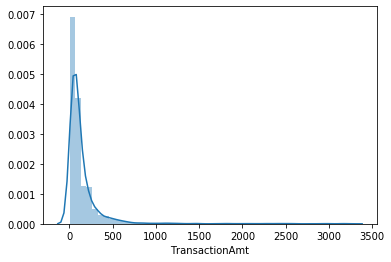

In [82]:
sns.distplot(X['TransactionAmt'])

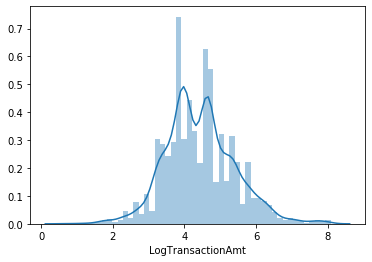

In [84]:
sns.distplot(X['LogTransactionAmt'])

# Agrupar los grupos pequeños en una sola categoría

In [95]:
value_counts = X.R_emaildomain.value_counts()
value_counts[value_counts < 300].index

Index(['gmail.com', 'anonymous.com', 'hotmail.com', 'yahoo.com', 'outlook.com',
       'yahoo.com.mx', 'aol.com', 'icloud.com', 'comcast.net', 'live.com.mx',
       'verizon.net', 'hotmail.es', 'msn.com', 'optonline.net', 'live.com',
       'mail.com', 'juno.com', 'prodigy.net.mx', 'me.com', 'bellsouth.net',
       'aim.com', 'gmx.de', 'ymail.com', 'outlook.es', 'att.net',
       'servicios-ta.com', 'charter.net'],
      dtype='object')

In [138]:
type_col in ['object', 'category']

TypeError: data type "category" not understood

In [147]:
cat = 'card4'

In [231]:
def group_small_cats_inplace(serie, prop=0.1):
    value_counts = serie.value_counts()
    # if we have less than 3 categories this is not useful
    if len(value_counts) <  3:
        return serie
    
    # Check type
    type_col = serie.dtype
    if  np.issubdtype(type_col, np.integer):
        import warnings
        warnings.warn("Float type is unexpected in category grouping. Please cast\
                        before to a object type or int")
        
    # Filter the grouped cats
    min_required = prop * len(serie)
    non_passing = value_counts[value_counts < min_required].index
    # If is object input others else input -1
    if type_col == 'O':
        serie.loc[ serie.isin(non_passing)] = 'Others'
    else:
        # If not, please be int, and please not be using -1
        serie.loc[ serie.isin(non_passing)] = -1
    return serie

In [232]:
cat = 

In [234]:
cat = 'card6'
group_small_cats_inplace(X['card6'], prop=.5)
print(X[cat].unique())

['credit' 'debit']


In [235]:
cat = 'card4'
group_small_cats_inplace(X[cat], prop=.3)
print(X[cat].unique())

['Others' 'mastercard' 'visa']
